In [1]:
import pandas as pd
import numpy as np
from ripser import ripser
from persim import plot_diagrams
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons
from matplotlib.lines import Line2D
import matplotlib
import warnings
import os
from data_cleaning import (
    calculate_indicator_summary, 
    summarize_data_wide, 
    input_missing_data, 
    standardize)
from homology import (
    safe_linspace,
    stable_rank,
    betti_curve,
    safe_interp
)

In [2]:
# ------------------------------
# 1. Load data
# ------------------------------
data_dir = "C:/Users/padil/Documents/TDA/DATA/"

data_countries = pd.read_csv(os.path.join(data_dir, "Data_countries.csv")) # Data for countries
data_regions = pd.read_csv(os.path.join(data_dir, "Data_regions.csv")) # Data for regions
world_regions_latest = pd.read_csv(os.path.join(data_dir,"clean_world_regions.csv")) # Map of countries into regions

In [4]:
# ------------------------------
# 2. Mappings
# ------------------------------
indicators = {
    'NY.GDP.PCAP.CD': 'gdp_per_capita',
    'NY.GDP.MKTP.KD.ZG': 'gdp_growth',
    'SP.DYN.LE00.IN': 'life_expectancy',
    'SP.DYN.IMRT.IN': 'infant_mortality',
    'SE.SEC.ENRR': 'school_enrollment',
    #'SE.ADT.LITR.ZS': 'literacy_rate',
    'SH.XPD.CHEX.GD.ZS': 'health_spending',
    #'SI.POV.GINI': 'gini',
    'SI.POV.DDAY': 'poverty',
    'SP.POP.GROW': 'pop_growth',
    'EG.ELC.ACCS.ZS': 'electricity_access'
}

wb_region_map = {
    "Latin America and Caribbean (WB)": "Latin America & Caribbean",
    "Sub-Saharan Africa (WB)": "Sub-Saharan Africa",
    "East Asia and Pacific (WB)": "East Asia & Pacific",
    "Europe and Central Asia (WB)": "Europe & Central Asia",
    "Middle East, North Africa, Afghanistan and Pakistan (WB)": "Middle East, North Africa, Afghanistan & Pakistan",
    "South Asia (WB)": "South Asia",
    "North America (WB)": "North America"
}

In [5]:
# ------------------------------
# 3. Build data matrix by filling empty indicators and dropping non-filled enough countries
# ------------------------------
calculations = ['median']

# Country level data
data_wide = summarize_data_wide(data_countries, indicators, calculations)

country_region_map = world_regions_latest.set_index('Code')['World regions according to WB'].map(wb_region_map).to_dict()
data_wide['region'] = data_wide['Country Code'].map(country_region_map)

# Region level data
data_region_wide = summarize_data_wide(data_regions, indicators, calculations)
data_region_wide = data_region_wide.rename(columns={'Country Name': 'region'})

data_wide_full = input_missing_data(data_wide, data_region_wide)

if 'gdp_per_capita' in data_wide_full.columns: # Log-transform GDP per capita safely
    data_wide_full['gdp_per_capita'] = data_wide_full['gdp_per_capita'].apply(lambda x: np.log10(x) if x>0 else np.nan)

X, countries, regions = standardize(data_wide_full)

In [47]:
X

array([[-0.81842315, -0.44568634,  1.38602467, ..., -1.22142447,
         1.32498321, -1.03455088],
       [ 0.6495661 ,  0.22105653, -0.06935976, ...,  0.8198865 ,
        -1.44503359,  0.5642782 ],
       [ 0.62143696, -0.18414501, -0.59398977, ...,  0.36658054,
         0.3123623 ,  0.06462914],
       ...,
       [-0.70414854,  0.06205602, -0.44704195, ..., -0.55072764,
         1.35456978, -1.37353235],
       [-1.8750238 ,  0.98031143, -0.61104039, ..., -1.54440348,
         1.41981026, -0.81243508],
       [-1.51637732, -0.96534558,  0.21472473, ..., -1.97763156,
         0.06982008, -1.33699265]], shape=(217, 7))

(array([ 1., 22., 31., 54., 46., 28., 18., 11.,  5.,  1.]),
 array([0.        , 0.68734287, 1.37468574, 2.06202862, 2.74937149,
        3.43671436, 4.12405723, 4.8114001 , 5.49874297, 6.18608585,
        6.87342872]),
 <BarContainer object of 10 artists>)

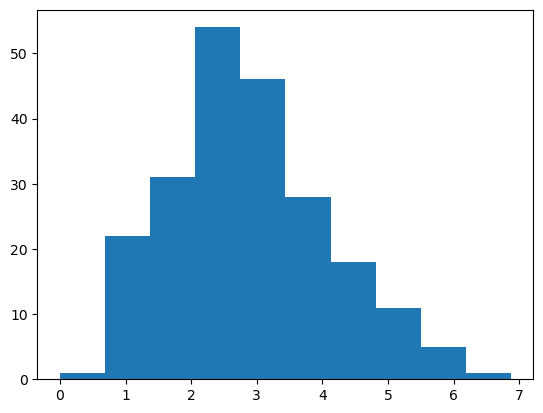

In [19]:
dist_matrix = squareform(pdist(X, metric='euclidean'))
plt.hist(dist_matrix[100])


Processing distribution: 0_50
Processing distribution: 25_75
Processing distribution: 50_100
Processing distribution: 75_125
Processing distribution: 100_150
Processing distribution: 125_175
Processing distribution: 150_200


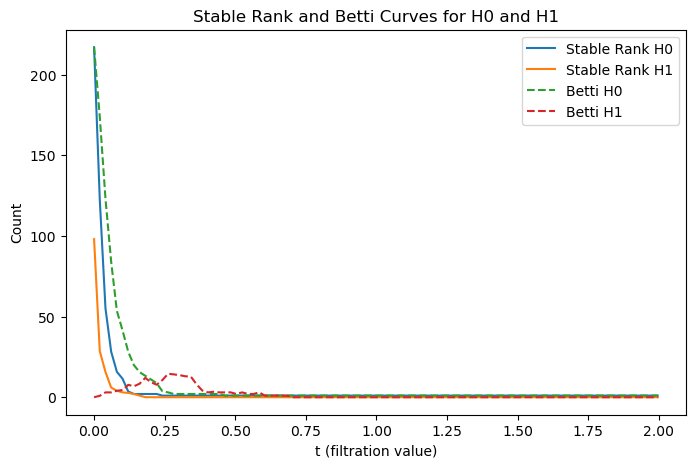

In [48]:
unique_regions = sorted(set(regions))
cmap = matplotlib.colormaps.get_cmap("tab10").resampled(len(unique_regions))
region_colors = {region: cmap(i) for i, region in enumerate(unique_regions)}

hemisphere_colors = {}
for region in unique_regions:
    if region in ["East Asia & Pacific", "Latin America & Caribbean", "Middle East, North Africa, Afghanistan & Pakistan", "South Asia", "Sub-Saharan Africa"]:
        hemisphere_colors[region] = "black"
    elif region in ["Europe & Central Asia", "North America"]:
        hemisphere_colors[region] = "red"
    else:
        # fallback (optional)
        hemisphere_colors[region] = "gray"

metrics = ["cosine"] # , "hamming", "mahalanobis"
for metric in metrics:
    dist_matrix = squareform(pdist(X, metric=metric))

    rips = ripser(dist_matrix, maxdim=1, distance_matrix=True)
    plt.figure()
    plot_diagrams(rips['dgms'], show=False, title="Persistence Diagrams")
    #plt.savefig(f"Persistence_{metric}.pdf", bbox_inches='tight')
    plt.close()

    homology_results = {}

    for dim, label in enumerate(["H0", "H1"]):
        diagram = rips["dgms"][dim]
        t_vals = safe_linspace(diagram, num=100, default_max=np.max(dist_matrix))

        # Stable Rank and Betti
        sr = stable_rank(diagram, t_vals, include_infinite=True)
        betti = betti_curve(diagram, t_vals)

        # Interpolate to a common t-grid (for comparison)
        t_uniform = np.linspace(0, np.max(dist_matrix), 100)
        sr_interp = safe_interp(t_uniform, t_vals, sr)
        betti_interp = safe_interp(t_uniform, t_vals, betti)

        homology_results[label] = {
            "diagram": diagram,
            "t_vals": t_vals,
            "sr": sr,
            "betti": betti,
            "t_uniform": t_uniform,
            "sr_uniform": sr_interp,
            "betti_uniform": betti_interp,
        }

    sr_H0 = homology_results["H0"]["sr_uniform"]
    betti_H0 = homology_results["H0"]["betti_uniform"]
    sr_H1 = homology_results["H1"]["sr_uniform"]
    betti_H1 = homology_results["H1"]["betti_uniform"]
    t_vals = homology_results["H0"]["t_uniform"]

    # Sampling
    number_data_points = X.shape[0]

    def uniform_distribution_interval(low, high):
        def f(distances):
            prob = np.clip((distances - low) / (high - low), 0, 1)
            if prob.sum() == 0:
                return np.ones_like(prob) / len(prob)
            return prob / prob.sum()
        return f

    distributions = {
        "0_50": uniform_distribution_interval(0, 50),
        "25_75": uniform_distribution_interval(25, 75),
        "50_100": uniform_distribution_interval(50, 100),
        "75_125": uniform_distribution_interval(75, 125),
        "100_150": uniform_distribution_interval(100, 150),
        "125_175": uniform_distribution_interval(125, 175),
        "150_200": uniform_distribution_interval(150, 200),
    }

    number_instances = 100    # number of random samples per base point
    sample_size = 10          # number of points in each sample
    t_len = 100               # number of t-values
    t_global = np.linspace(0, np.max(dist_matrix), t_len)  # common t-grid

    sr_H0_samp, sr_H1_samp = {k: [] for k in distributions}, {k: [] for k in distributions}
    betti_H0_samp, betti_H1_samp = {k: [] for k in distributions}, {k: [] for k in distributions}

    # --- Main sampling loop ---
    for k, dist_func in distributions.items():
        print(f"Processing distribution: {k}")
        for i in range(number_data_points):
            p = dist_func(dist_matrix[i])

            # Generate multiple random subsets
            sampled_indices = []
            for _ in range(number_instances):
                sampled_indices.append(np.random.choice(number_data_points, size=sample_size, p=p))
            sampled_indices = np.unique(np.concatenate(sampled_indices))

            # Skip trivial subsets
            if len(sampled_indices) < 2:
                sr_H0_samp[k].append(np.zeros(t_len))
                sr_H1_samp[k].append(np.zeros(t_len))
                betti_H0_samp[k].append(np.zeros(t_len))
                betti_H1_samp[k].append(np.zeros(t_len))
                continue

            X_subset = X[sampled_indices]
            rips = ripser(X_subset, maxdim=1)
            H0_dgm, H1_dgm = rips['dgms']

            # H0 computations
            t_local_H0 = safe_linspace(H0_dgm, t_len, default_max=np.max(dist_matrix))
            sr0 = stable_rank(H0_dgm, t_local_H0)
            betti0 = betti_curve(H0_dgm, t_local_H0)
            sr_H0_samp[k].append(safe_interp(t_global, t_local_H0, sr0))
            betti_H0_samp[k].append(safe_interp(t_global, t_local_H0, betti0))

            # H1 computations
            t_local_H1 = safe_linspace(H1_dgm, t_len, default_max=np.max(dist_matrix))
            sr1 = stable_rank(H1_dgm, t_local_H1)
            betti1 = betti_curve(H1_dgm, t_local_H1)
            sr_H1_samp[k].append(safe_interp(t_global, t_local_H1, sr1))
            betti_H1_samp[k].append(safe_interp(t_global, t_local_H1, betti1))

    plt.figure(figsize=(8, 5))
    plt.plot(t_vals, sr_H0, label="Stable Rank H0")
    plt.plot(t_vals, sr_H1, label="Stable Rank H1")
    plt.plot(t_vals, betti_H0, '--', label="Betti H0")
    plt.plot(t_vals, betti_H1, '--', label="Betti H1")
    plt.xlabel("t (filtration value)")
    plt.ylabel("Count")
    plt.title("Stable Rank and Betti Curves for H0 and H1")
    plt.legend()
    plt.show()


In [49]:
# --- Distributions ---
distribution_names = list(distributions.keys())
n_distributions = len(distribution_names)
number_samples = len(regions)

# --- Homology / curves dictionaries ---
homology_types = {
    'H0': sr_H0_samp,
    'H1': sr_H1_samp,
    'Betti0': betti_H0_samp,
    'Betti1': betti_H1_samp
}
homology_labels = ['H0', 'H1', 'Betti0', 'Betti1']


# Classif

In [50]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from datetime import timedelta


In [51]:
region = data_wide['region']
south = ["East Asia & Pacific", "Latin America & Caribbean", "Middle East, North Africa, Afghanistan & Pakistan", "South Asia", "Sub-Saharan Africa"]
label = region.apply(lambda x: 1 if x in south else 0).values
X_train, X_test, y_train, y_test = train_test_split(np.arange(len(data_wide)), 
                                                    label, 
                                                    test_size=0.8)

In [52]:
train = [X[i] for i in X_train]
test = [X[i] for i in  X_test]

start = timer()    

kernel_train = np.asarray([[np.dot(f,g) for g in train] for f in train])
kernel_test = np.asarray([[np.dot(f,g) for g in train] for f in test])

end = timer()
print(timedelta(seconds=end-start))

0:00:00.013004


In [53]:
clf = svm.SVC(kernel='precomputed')
clf.fit(kernel_train, y_train)
prediction = clf.predict(kernel_test )
a_score = accuracy_score(y_test, prediction)
print("classification accuracy: ", a_score)

classification accuracy:  0.867816091954023


In [54]:
h0_kernel_train = {}
h0_kernel_test = {}
h0_prediction = {}
h0_a_score = {}
start = timer()  

for k in distributions.keys():
    h0_train = [sr_H0_samp[k][i] for i in X_train]
    h0_test = [sr_H0_samp[k][i] for i in X_test]
    kernel_train = np.asarray([[f.dot(g) for g in h0_train] for f in h0_train])
    kernel_test = np.asarray([[f.dot(g) for g in h0_train] for f in h0_test])
    h0_kernel_train[k] = kernel_train
    h0_kernel_test[k] = kernel_test
    clf = svm.SVC(kernel='precomputed')
    clf.fit(kernel_train, y_train)
    pred = clf.predict(kernel_test )
    h0_prediction[k] = pred
    h0_a_score[k] = accuracy_score(y_test, pred)
    print(k)
end = timer()
print("h0 pred: ", timedelta(seconds=end-start))

0_50
25_75
50_100
75_125
100_150
125_175
150_200
h0 pred:  0:00:00.070811


In [55]:
for k in h0_a_score.keys():
    print("distribution "+k+", h0 score:", round(h0_a_score[k],2))

distribution 0_50, h0 score: 0.72
distribution 25_75, h0 score: 0.63
distribution 50_100, h0 score: 0.64
distribution 75_125, h0 score: 0.66
distribution 100_150, h0 score: 0.66
distribution 125_175, h0 score: 0.67
distribution 150_200, h0 score: 0.52


In [56]:
h0_wrong_class = {}
for k in  distributions.keys():
    h0_wrong_class[k] = {}
    indx = []
    values = []
    pred = []
    for i in range(len(h0_prediction[k])):
        v = y_test[i]
        p = h0_prediction[k][i]
        if v != p:
            indx.append(i)
            values.append(v)
            pred.append(p)
        h0_wrong_class[k]["index"] = indx
        h0_wrong_class[k]["value"] = values
        h0_wrong_class[k]["prediction"] = pred

In [57]:
print(h0_wrong_class["25_75"]['index'])
data_wide['Country Name'].iloc[h0_wrong_class["0_50"]['index']]


[1, 2, 4, 12, 16, 19, 20, 22, 25, 26, 29, 30, 34, 35, 36, 41, 47, 48, 49, 52, 57, 58, 59, 61, 63, 66, 70, 72, 74, 85, 86, 89, 90, 91, 98, 102, 105, 107, 109, 112, 115, 119, 121, 123, 124, 125, 126, 133, 138, 139, 140, 141, 144, 150, 151, 153, 157, 158, 161, 162, 163, 168, 169, 172, 173]


0                    Afghanistan
1                        Albania
2                        Algeria
4                        Andorra
7                      Argentina
12                    Azerbaijan
16                      Barbados
19                        Belize
20                         Benin
26                        Brazil
28             Brunei Darussalam
36                Cayman Islands
37      Central African Republic
41                         China
47                 Cote d'Ivoire
48                       Croatia
49                          Cuba
59                   El Salvador
61                       Eritrea
65                 Faroe Islands
68                        France
70                         Gabon
72                       Georgia
75                     Gibraltar
79                          Guam
80                     Guatemala
83                        Guyana
86          Hong Kong SAR, China
90                     Indonesia
92                          Iraq
99        